Ersten Schritte der Datenverarbeitung testen

Daten in verteilter Datenstruktur laden

In [12]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

testdatadir = '../data/raw/*.csv'

spark = SparkSession.builder.appName('placegroups').getOrCreate()
dataFrame = spark.read.option('header',True).csv(testdatacsv)

Kann man die Daten jetzt per Nutzer aggregieren?

In [13]:
dataFrame.printSchema
dataFrame.show(5)

root
 |-- timestamp: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- pixel_color: string (nullable = true)
 |-- coordinate: string (nullable = true)

+--------------------+--------------------+-----------+----------+
|           timestamp|             user_id|pixel_color|coordinate|
+--------------------+--------------------+-----------+----------+
|2022-04-04 04:38:...|vKtmwRQwAYtw5poO4...|    #FF3881|  804,1992|
|2022-04-04 04:38:...|eoZO4uYgBzVoDR0Rb...|    #FFFFFF|  1667,616|
|2022-04-04 04:38:...|Mdd6j8t/24pCeslV3...|    #D4D7D9|   392,467|
|2022-04-04 04:38:...|xHWcOdv98PR7yQNKD...|    #000000|   21,1691|
|2022-04-04 04:38:...|hI0Z36Jzkw+coR+im...|    #515252|  971,1026|
+--------------------+--------------------+-----------+----------+
only showing top 5 rows



In [26]:
from pyspark.sql.functions import col, asc, desc

grouped = dataFrame.groupBy('user_id')
active = grouped.count().orderBy(col('count').desc())
active.show(5)

+--------------------+-----+
|             user_id|count|
+--------------------+-----+
|AxBTmhBMbr1sbDw/2...|   20|
|FjHp8Fg+uuheibUWk...|   15|
|X8gpDfO6+Z87SKKTy...|   15|
|VmiTfdqG3P1MlZokx...|   15|
|DIECtVqoJqBlL6A0C...|   15|
+--------------------+-----+
only showing top 5 rows



```
+--------------------+-----+
|             user_id|count|
+--------------------+-----+
|AxBTmhBMbr1sbDw/2...|   20|
|FjHp8Fg+uuheibUWk...|   15|
|X8gpDfO6+Z87SKKTy...|   15|
|VmiTfdqG3P1MlZokx...|   15|
|DIECtVqoJqBlL6A0C...|   15|
+--------------------+-----+
only showing top 5 rows
```

Wir versuchen mal die Daten für den aktivsten Nutzer zu aggregieren

In [30]:
mostactive = active.first()
mostactiveid = mostactive.asDict()['user_id']
topFrame = dataFrame.filter("user_id == '"+mostactiveid+"'")

In [50]:
from datetime import datetime
import time

onetime = '2022-04-04 04:38:15.038 UTC'

def stamp2time(stamp):
    d =  datetime.strptime(stamp,"%Y-%m-%d %H:%M:%S.%f UTC")
    return int(time.mktime(d.timetuple()))

print(stamp2time(onetime))

1649047095


In [58]:
mappedRDD = topFrame.rdd.map(lambda x: (x[1],x[3].split(',')[0],x[3].split(',')[1],stamp2time(x[0]),x[2]))

('AxBTmhBMbr1sbDw/2liFySQ4h6lH1bZSyjS9RtcBxvMyafVj+e2grv9teqbU9JkFDCPlgIfWH+L2CzKeSBdB4w==', '1611', '33', 1649050364.0, '#2450A4')
('AxBTmhBMbr1sbDw/2liFySQ4h6lH1bZSyjS9RtcBxvMyafVj+e2grv9teqbU9JkFDCPlgIfWH+L2CzKeSBdB4w==', '584', '26', 1649050672.0, '#000000')

In [75]:
(uid,xs,ys,ts,fs) = list(zip(*mappedRDD.collect()))

In [87]:
print(min(ts))
xs = list(xs)
ys = list(ys)
ts = list(ts)
normalizedts = list(map(lambda x: x - min(ts), ts))
print(list(xs))
print(ys)
print(normalizedts)


1649047279
['1447', '1636', '1287', '1926', '1310', '1617', '655', '612', '1575', '658', '1403', '777', '1741', '1299', '586', '788', '656', '1611', '584', '1765']
['5', '21', '8', '19', '10', '16', '1896', '1917', '7', '14', '2', '8', '10', '20', '1931', '11', '1884', '33', '26', '8']
[0, 308, 617, 617, 925, 1233, 1542, 1542, 1542, 1851, 2160, 2160, 2160, 2469, 2469, 2777, 2777, 3085, 3393, 3393]


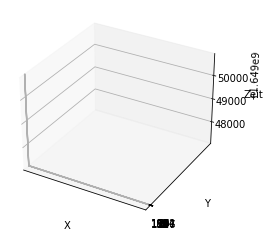

In [90]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')



ax.scatter(xs,ys,ts,"o")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Zeit')

plt.show()
